# Introduction

## Goal 1:

### Loading Libraries

In [488]:
#importing libraries
import numpy as np 
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import scipy.optimize as opt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from math import sqrt
from scipy.optimize import curve_fit

### Defining functions for normalisation

In [489]:
def norm(array):
    """ Returns array normalised to [0,1] """
    min_val = np.min(array)
    max_val = np.max(array)
    scaled = (array - min_val) / (max_val - min_val)

    return scaled


def norm_df(df):
    """ 
    Returns all columns of the dataframe normalised to [0,1] with the 
    exception the first (containing the names)
    Calls function norm to do the normalisation of one column, but
    doing all in one function is also fine. 
    """
    # iterate over all columns
    for col in df.columns[1:]: # excluding the first column
        df[col] = norm(df[col])
        
    return df

### Defining functions for model fitting

In [490]:
def exp_growth(t, scale, growth):
    """ Computes exponential function with scale and growth as free parameters"""
    f = scale * np.exp(growth * (t-1950)) 
    
    return f
        

def logistics(t, a, k, t0):
    """ Computes logistics function with scale and incr as free parameters"""
    f = a / (1.0 + np.exp(-k * (t - t0)))
    
    return f

### Reading and exploring the .csv file

In [491]:
#reading .csv file
df = pd.read_csv('API_19_DS2_en_csv_v2_3358246.csv', header=2)

#looking at the first 5 rows
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,Urban population (% of total population),SP.URB.TOTL.IN.ZS,50.78,50.76,50.75,50.73,50.72,50.70,...,42.96,42.99,43.04,43.11,43.19,43.29,43.41,43.55,43.70,NaN
1,Aruba,ABW,Urban population,SP.URB.TOTL,27525.00,28139.00,28537.00,28763.00,28922.00,29080.00,...,44059.00,44351.00,44666.00,44978.00,45293.00,45614.00,45949.00,46294.00,46654.00,NaN
2,Aruba,ABW,Urban population growth (annual %),SP.URB.GROW,NaN,2.21,1.40,0.79,0.55,0.54,...,0.54,0.66,0.71,0.70,0.70,0.71,0.73,0.75,0.77,NaN
3,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.00,55434.00,56234.00,56699.00,57029.00,57357.00,...,102565.00,103165.00,103776.00,104339.00,104865.00,105361.00,105846.00,106310.00,106766.00,NaN
4,Aruba,ABW,Population growth (annual %),SP.POP.GROW,NaN,2.24,1.43,0.82,0.58,0.57,...,0.50,0.58,0.59,0.54,0.50,0.47,0.46,0.44,0.43,NaN


### Data Cleaning and reformatting for usability and understanding

In [492]:
#replacing spaces'' in column names with '_' for naming convention
df.columns = df.columns.str.replace(' ', '_')

#dropping code columns like Country_Code and Indicator_Code and Unnamed: 65
df.drop(df.columns[[1, 3, 65]], axis = 1, inplace = True)

#formating all float values to 2 decimal points
pd.options.display.float_format = '{:.2f}'.format

df.head() #Looking at the first 5 rows

,Country_Name,Indicator_Name,1960,1961,1962,1963,1964,1965,1966,1967,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,Urban population (% of total population),50.78,50.76,50.75,50.73,50.72,50.70,50.69,50.67,...,42.94,42.96,42.99,43.04,43.11,43.19,43.29,43.41,43.55,43.70
1,Aruba,Urban population,27525.00,28139.00,28537.00,28763.00,28922.00,29080.00,29246.00,29411.00,...,43820.00,44059.00,44351.00,44666.00,44978.00,45293.00,45614.00,45949.00,46294.00,46654.00
2,Aruba,Urban population growth (annual %),NaN,2.21,1.40,0.79,0.55,0.54,0.57,0.56,...,0.10,0.54,0.66,0.71,0.70,0.70,0.71,0.73,0.75,0.77
3,Aruba,"Population, total",54208.00,55434.00,56234.00,56699.00,57029.00,57357.00,57702.00,58044.00,...,102050.00,102565.00,103165.00,103776.00,104339.00,104865.00,105361.00,105846.00,106310.00,106766.00
4,Aruba,Population growth (annual %),NaN,2.24,1.43,0.82,0.58,0.57,0.60,0.59,...,0.38,0.50,0.58,0.59,0.54,0.50,0.47,0.46,0.44,0.43


In [493]:
#looking at the column names and data types
df.dtypes

Country_Name       object
Indicator_Name     object
1960              float64
1961              float64
1962              float64
                   ...   
2016              float64
2017              float64
2018              float64
2019              float64
2020              float64
Length: 63, dtype: object

In [494]:
#looking for unique rows under column "Indicator_Name"
df.sort_values("Indicator_Name", inplace = True)#sorting in ascending order
df["Indicator_Name"].unique()

array(['Access to electricity (% of population)',
       'Agricultural irrigated land (% of total agricultural land)',
       'Agricultural land (% of land area)', 'Agricultural land (sq. km)',
       'Agriculture, forestry, and fishing, value added (% of GDP)',
       'Annual freshwater withdrawals, total (% of internal resources)',
       'Annual freshwater withdrawals, total (billion cubic meters)',
       'Arable land (% of land area)',
       'Average precipitation in depth (mm per year)',
       'CO2 emissions (kg per 2015 US$ of GDP)',
       'CO2 emissions (kg per 2017 PPP $ of GDP)',
       'CO2 emissions (kg per PPP $ of GDP)', 'CO2 emissions (kt)',
       'CO2 emissions (metric tons per capita)',
       'CO2 emissions from gaseous fuel consumption (% of total)',
       'CO2 emissions from gaseous fuel consumption (kt)',
       'CO2 emissions from liquid fuel consumption (% of total)',
       'CO2 emissions from liquid fuel consumption (kt)',
       'CO2 emissions from solid 

In [495]:
#looking for unique rows under column "Country_Name"
df.sort_values("Country_Name", inplace = True)#sorting in ascending order
df["Country_Name"].unique()

array(['Afghanistan', 'Africa Eastern and Southern',
       'Africa Western and Central', 'Albania', 'Algeria',
       'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda',
       'Arab World', 'Argentina', 'Armenia', 'Aruba', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'British Virgin Islands', 'Brunei Darussalam',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia',
       'Cameroon', 'Canada', 'Caribbean small states', 'Cayman Islands',
       'Central African Republic', 'Central Europe and the Baltics',
       'Chad', 'Channel Islands', 'Chile', 'China', 'Colombia', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire",
       'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic',
       'Denmark', 'Djibouti', 'Dominica', 'Dominica

### Selecting indicators: Electric power consumption and Electricity production sources

In [496]:
#Selecting indicators based on electricity consumption and production:
indicator_list = ['Electric power consumption (kWh per capita)',
                  'Electricity production from coal sources (% of total)',
                  'Electricity production from hydroelectric sources (% of total)',
                  'Electricity production from oil sources (% of total)',
                  'Electricity production from renewable sources, excluding hydroelectric (% of total)']

In [497]:
#Selecting few countries from each continent
country_list = ['Austria','Belgium','France','Germany','Ireland','Italy',
                'Norway','Russian Federation','Spain', 'Sweden','Switzerland','United Kingdom',
                
                'Bangladesh','China','India','Japan','Oman','Pakistan','Qatar','Saudi Arabia',
                'Singapore','United Arab Emirates',
                
                'Canada','Mexico','United States','Argentina','Bolivia','Brazil','Uruguay',
                
                'Australia','New Zealand',
                
                'Cameroon','Egypt, Arab Rep.','Nigeria','South Africa']

In [498]:
#Filtering Country_Name by Country list and indicator >> 'Electric power consumption (kWh per capita)'
df_powerconsumption = df.loc[(df.Country_Name.isin(country_list)) & 
                      (df.Indicator_Name == 'Electric power consumption (kWh per capita)')]
#dropping column Indicator_Name
df_powerconsumption.drop(df_powerconsumption.columns[[1]], axis = 1, inplace = True)
#creating column with average values
df_powerconsumption['avg_pc'] = df_powerconsumption.mean(axis=1)
df_powerconsumption = df_powerconsumption.reset_index(drop=True)


#Filtering Country_Name by Country list and indicator >>'Electricity production from coal sources (% of total)'
df_coalsrc = df.loc[(df.Country_Name.isin(country_list)) & 
                      (df.Indicator_Name == 'Electricity production from coal sources (% of total)')]
#dropping column Indicator_Name
df_coalsrc.drop(df_coalsrc.columns[[1]], axis = 1, inplace = True)
#creating column with average values
df_coalsrc['avg_coalsrc'] = df_coalsrc.mean(axis=1)
df_coalsrc = df_coalsrc.reset_index(drop=True)


#Filtering Country_Name by Country list and indicator >>'Electricity production from hydroelectric sources (% of total)'
df_hydsrc = df.loc[(df.Country_Name.isin(country_list)) & 
                      (df.Indicator_Name == 'Electricity production from hydroelectric sources (% of total)')]
#dropping column Indicator_Name
df_hydsrc.drop(df_hydsrc.columns[[1]], axis = 1, inplace = True)
#creating column with average values
df_hydsrc['avg_hydsrc'] = df_hydsrc.mean(axis=1)
df_hydsrc = df_hydsrc.reset_index(drop=True)


#Filtering Country_Name by Country list and indicator >>'Electricity production from oil sources (% of total))'
df_oilsrc = df.loc[(df.Country_Name.isin(country_list)) & 
                      (df.Indicator_Name == 'Electricity production from oil sources (% of total)')]
#dropping column Indicator_Name
df_oilsrc.drop(df_oilsrc.columns[[1]], axis = 1, inplace = True)
#creating column with average values
df_oilsrc['avg_oilsrc'] = df_oilsrc.mean(axis=1)
df_oilsrc = df_oilsrc.reset_index(drop=True)


#Filtering Country_Name by Country list and indicator >>'Electricity production from renewable sources, excluding hydroelectric (% of total)'
df_renewsrc = df.loc[(df.Country_Name.isin(country_list)) & 
                      (df.Indicator_Name == 'Electricity production from renewable sources, excluding hydroelectric (% of total)')]
#dropping column Indicator_Name
df_renewsrc.drop(df_renewsrc.columns[[1]], axis = 1, inplace = True)
#creating column with average values
df_renewsrc['avg_renewsrc'] = df_renewsrc.mean(axis=1)
df_renewsrc = df_renewsrc.reset_index(drop=True)

C:\Users\nidhi\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\nidhi\AppData\Local\Temp/ipykernel_19052/1618132947.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_powerconsumption['avg_pc'] = df_powerconsumption.mean(axis=1)
C:\Users\nidhi\AppData\Local\Temp/ipykernel_19052/1618132947.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [499]:
# normalising dataframes
df_powerconsumption = norm_df(df_powerconsumption)
df_coalsrc = norm_df(df_coalsrc)
df_hydsrc = norm_df(df_hydsrc)
df_oilsrc = norm_df(df_oilsrc)
df_renewsrc = norm_df(df_renewsrc)

In [500]:
#Populating cluster for analysis
df_cluster = pd.DataFrame(df_powerconsumption['Country_Name'])
df_cluster = df_cluster.join(df_powerconsumption['avg_pc'])
df_cluster = df_cluster.join(df_coalsrc['avg_coalsrc'])
df_cluster = df_cluster.join(df_hydsrc['avg_hydsrc'])
df_cluster = df_cluster.join(df_oilsrc['avg_oilsrc'])
df_cluster = df_cluster.join(df_renewsrc['avg_renewsrc'])
df_cluster

,Country_Name,avg_pc,avg_coalsrc,avg_hydsrc,avg_oilsrc,avg_renewsrc
0,Argentina,0.08,0.02,0.31,0.30,0.07
1,Australia,0.35,0.79,0.13,0.04,0.14
2,Austria,0.27,0.12,0.67,0.09,0.34
3,Bangladesh,0.00,0.01,0.11,0.23,0.00
4,Belgium,0.28,0.31,0.01,0.23,0.21
5,Bolivia,0.01,0.00,0.55,0.08,0.15
6,Brazil,0.07,0.03,0.88,0.06,0.30
7,Cameroon,0.01,0.00,0.93,0.09,0.05
8,Canada,0.67,0.16,0.67,0.04,0.11
9,China,0.05,0.73,0.19,0.14,0.06


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Electric Power Consumption')

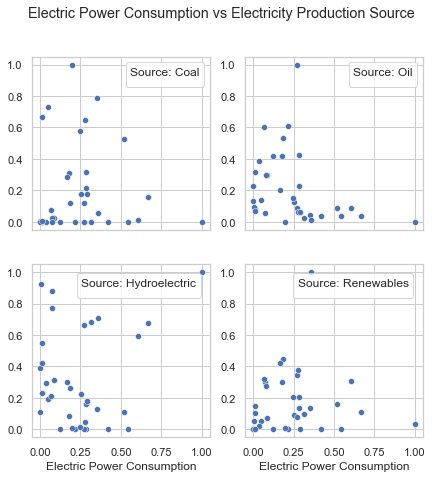

In [502]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(7,7))

fig.suptitle('Electric Power Consumption vs Electricity Production Source')

sns.scatterplot(ax=axes[0, 0], data=df_cluster, x='avg_pc', y='avg_coalsrc')
axes[0,0].legend(title='Source: Coal')
sns.scatterplot(ax=axes[0, 1], data=df_cluster, x='avg_pc', y='avg_oilsrc')
axes[0,1].legend(title='Source: Oil')
sns.scatterplot(ax=axes[1, 0], data=df_cluster, x='avg_pc', y='avg_hydsrc')
axes[1,0].legend(title='Source: Hydroelectric', loc=1, bbox_to_anchor=(0.98,0.98))
sns.scatterplot(ax=axes[1, 1], data=df_cluster, x='avg_pc', y='avg_renewsrc')
axes[1,1].legend(title='Source: Renewables', loc=2, bbox_to_anchor=(0.24,0.98))

axes[0,0].set_ylabel("")
axes[0,1].set_ylabel("")
axes[1,0].set_ylabel("")
axes[1,1].set_ylabel("")
axes[1,0].set_xlabel("Electric Power Consumption")
axes[1,1].set_xlabel("Electric Power Consumption")

### Cluster of Electricity consumption to Electricity production by coal looks more clear

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


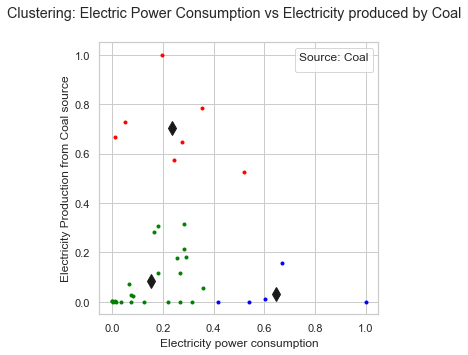

In [515]:
####### kmeans set up the clusterer, 3 expected clusters
kmeans = cluster.KMeans(n_clusters=3)

# extract columns for fitting
df_fit = df_cluster[["avg_pc", "avg_coalsrc"]].copy()
kmeans.fit(df_fit)     

# extract labels and cluster centres
labels = kmeans.labels_
cen = kmeans.cluster_centers_

# plot using the labels to select colour
plt.figure(figsize=(5.0,5.0))

col = ["blue", "red", "green"]
for l in range(3):     # loop over the different labels
    plt.plot(df_fit["avg_pc"][labels==l], df_fit["avg_coalsrc"][labels==l], "o", markersize=3, color=col[l])
    
# show cluster centres
for ic in range(3):
    xc, yc = cen[ic,:]
    plt.plot(xc, yc, "dk", markersize=10)
    

plt.suptitle('Clustering: Electric Power Consumption vs Electricity produced by Coal')    
plt.legend(title='Source: Coal')
plt.xlabel("Electricity power consumption")
plt.ylabel("Electricity Production from Coal source")
plt.show()

## Goal 2: 

### Looking at electricity production by renewable sources in India

In [504]:
#Filtering Country_Name by World and indicator >>'Electricity production from renewable sources, excluding hydroelectric (% of total)'
df_India = df.loc[(df.Country_Name.isin(country_list)) & 
                      (df.Indicator_Name == 'Electricity production from renewable sources, excluding hydroelectric (% of total)')]
#dropping column Indicator_Name
df_India.drop(df_India.columns[[1]], axis = 1, inplace = True)
#transposing the dataframe
df_India = df_India.set_index('Country_Name').transpose(copy=True)#copy-True to retain datatypes after transpose
#resetting index
df_India.reset_index(inplace=True)
#renaming column label from index to Year
df_India = df_India.rename(columns={"index": "Year"}) 
#removing column name label
df_India.columns.name='' 
#dropping columns with all NaN values
df_India = df_India.dropna()
df_India = df_India.reset_index(drop=True)
#converting to Year column to dtype numeric
df_India['Year'] =pd.to_numeric(df_India['Year'])
#droping all columns except Years and United Kingdom
df_India = df_India.drop(['Argentina', 'Australia', 'Austria', 'Bangladesh', 'Belgium', 'Bolivia',
       'Brazil', 'Cameroon', 'Canada', 'China', 'Egypt, Arab Rep.', 'France',
       'Germany', 'United Kingdom', 'Ireland', 'Italy', 'Japan', 'Mexico',
       'New Zealand', 'Nigeria', 'Norway', 'Oman', 'Pakistan', 'Qatar',
       'Russian Federation', 'Saudi Arabia', 'Singapore', 'South Africa',
       'Spain', 'Sweden', 'Switzerland', 'United Arab Emirates',
       'United States', 'Uruguay'], axis=1)
df_India = df_India.rename(columns={"India": "RenewSource"})

C:\Users\nidhi\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Exponential Function Model: Electricity production by Renewable Source in India

Fit parameter [3.17568174e-05 1.89757345e-01]


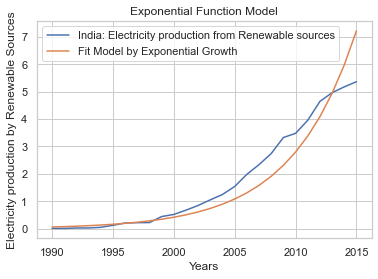


According to Exponential model, Electricity production by Renewable Sources in India by..
2016: 8.728395890703323
2017: 10.552248347828156
2018: 12.757206087872532
2019: 15.42290342341572
2020: 18.645614750563045
2021: 22.541731597604592
2022: 27.251966224556966
2023: 32.946433590900966
2024: 39.83079523199776
2025: 48.15368693658811


In [516]:
df_India["rn_error"] = np.sqrt(df_India["RenewSource"])

# fit exponential growth
popt, pcorr = opt.curve_fit(exp_growth, df_India["Year"], df_India["RenewSource"], 
                            sigma =  df_India["rn_error"], absolute_sigma = True,  
                            p0 = [4e8, 0.06])

print("Fit parameter", popt)
df_India["exp_rn"] = exp_growth(df_India["Year"], *popt)

# Plot Actual vs Expected Data
plt.figure()
plt.plot(df_India["Year"], df_India["RenewSource"], label = "India: Electricity production from Renewable sources")
plt.plot(df_India["Year"], df_India["exp_rn"], label = "Fit Model by Exponential Growth")

plt.legend()
plt.xlabel('Years')
plt.ylabel('Electricity production by Renewable Sources')
plt.title("Exponential Function Model")
plt.show()
print()

# predicting data based on the trained model
print("According to Exponential model, Electricity production by Renewable Sources in India by..")
print("2016:", exp_growth(2016, *popt))
print("2017:", exp_growth(2017, *popt))
print("2018:", exp_growth(2018, *popt))
print("2019:", exp_growth(2019, *popt))
print("2020:", exp_growth(2020, *popt))
print("2021:", exp_growth(2021, *popt))
print("2022:", exp_growth(2022, *popt))
print("2023:", exp_growth(2023, *popt))
print("2024:", exp_growth(2024, *popt))
print("2025:", exp_growth(2025, *popt))

### Logistic Function Model: Electricity production by Renewable Source in India

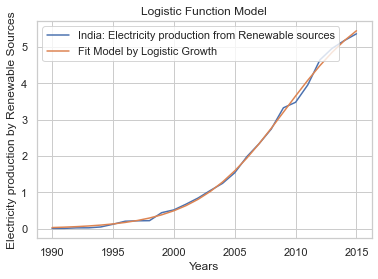


According to Logistic Model, Electricity production by Renewable Sources in India by..
2016: 5.672623626915379
2017: 5.859352422700806
2018: 6.009868798147163
2019: 6.129670417605193
2020: 6.2240685713065504
2021: 6.2978608412785455
2022: 6.355187456539695
2023: 6.399507607773938
2024: 6.433644293017463
2025: 6.4598616821877215


In [507]:
popt, pcorr = opt.curve_fit(logistics, df_India["Year"], df_India["RenewSource"], 
                            p0=(2e9, 0.5, 2000.0))

df_India["rn_exp"] = logistics(df_India["Year"], *popt)

plt.figure()
plt.plot(df_India["Year"], df_India["RenewSource"], label="India: Electricity production from Renewable sources")
plt.plot(df_India["Year"], df_India["rn_exp"], label="Fit Model by Logistic Growth")

plt.legend()
plt.xlabel("Years")
plt.ylabel("Electricity production by Renewable Sources")
plt.title("Logistic Function Model")
plt.show()
print()

print("According to Logistic Model, Electricity production by Renewable Sources in India by..")
print("2016:", logistics(2016, *popt))
print("2017:", logistics(2017, *popt))
print("2018:", logistics(2018, *popt))
print("2019:", logistics(2019, *popt))
print("2020:", logistics(2020, *popt))
print("2021:", logistics(2021, *popt))
print("2022:", logistics(2022, *popt))
print("2023:", logistics(2023, *popt))
print("2024:", logistics(2024, *popt))
print("2025:", logistics(2025, *popt))

## Goal 3: 

In [508]:
#Filtering Country_Name by India and indicators

df_compare = df.loc[(df.Country_Name == 'India') & 
                      (df.Indicator_Name.isin(indicator_list))]
#dropping column Indicator_Name
df_compare.drop(df_compare.columns[[1]], axis = 1, inplace = True)
#transposing the dataframe
df_compare = df_compare.set_index('Country_Name').transpose(copy=True)#copy-True to retain datatypes after transpose
#resetting index
df_compare.reset_index(inplace=True)
#renaming column label from index to Year
df_compare = df_compare.rename(columns={"index": "Year"}) 
#removing column name label
df_compare.columns.name='' 
#dropping columns with all NaN values
df_compare = df_compare.dropna()
df_compare = df_compare.reset_index(drop=True)
#converting to Year column to dtype numeric
df_compare['Year'] =pd.to_numeric(df_compare['Year'])
# Changing columns name with index number
df_compare.columns.values[1] = "Coal"
df_compare.columns.values[2] = "Oil"
df_compare.columns.values[3] = "Hydroelectric"
df_compare.columns.values[4] = "Renewable"
df_compare.columns.values[5] = "Power Consumption"
df_compare

C:\Users\nidhi\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Year,Coal,Oil,Hydroelectric,Renewable,Power Consumption
0,1971,49.09,6.32,42.22,0.00,97.77
1,1972,52.02,7.13,38.58,0.00,100.31
2,1973,49.39,7.02,39.81,0.00,100.63
3,1974,53.52,6.64,36.36,0.00,103.99
4,1975,51.33,6.24,38.77,0.00,114.56
5,1976,54.15,5.50,36.44,0.00,124.12
6,1977,52.99,5.76,38.43,0.00,126.26
7,1978,48.32,5.82,42.83,0.00,135.92
8,1979,49.88,6.73,40.32,0.00,135.74
9,1980,51.04,7.28,38.67,0.00,141.71


Text(0.5, 0, 'Year')

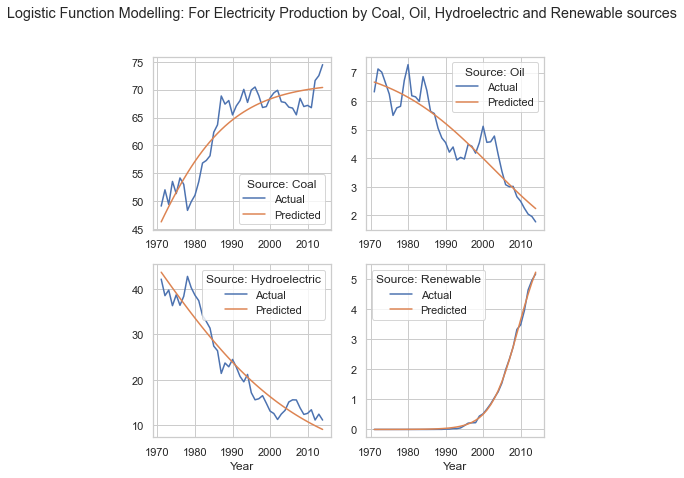

In [510]:
#Coal Source
popt1, pcorr = opt.curve_fit(logistics, df_compare["Year"], df_compare["Coal"], 
                            p0=(2e9, 0.5, 2000.0))
df_compare["Coal_exp"] = logistics(df_compare["Year"], *popt1)

#Oil Source
popt2, pcorr = opt.curve_fit(logistics, df_compare["Year"], df_compare["Oil"], 
                            p0=(2e9, 0.5, 2000.0))
df_compare["Oil_exp"] = logistics(df_compare["Year"], *popt2)

#Hydroelectric Source
popt3, pcorr = opt.curve_fit(logistics, df_compare["Year"], df_compare["Hydroelectric"], 
                            p0=(2e9, 0.5, 2000.0))
df_compare["Hydroelectric_exp"] = logistics(df_compare["Year"], *popt3)

#Renewable Source
popt4, pcorr = opt.curve_fit(logistics, df_compare["Year"], df_compare["Renewable"], 
                            p0=(2e9, 0.5, 2000.0))
df_compare["Renewable_exp"] = logistics(df_compare["Year"], *popt4)


fig, axes = plt.subplots(2, 2,  figsize=(7,7))
fig.suptitle('Logistic Function Modelling: For Electricity Production by Coal, Oil, Hydroelectric and Renewable sources')

sns.lineplot(ax=axes[0, 0], data=df_compare, x='Year', y='Coal', label = 'Actual')
sns.lineplot(ax=axes[0, 0], data=df_compare, x='Year', y='Coal_exp', label = 'Predicted')
axes[0,0].legend(title='Source: Coal')

sns.lineplot(ax=axes[0, 1], data=df_compare, x='Year', y='Oil', label = 'Actual')
sns.lineplot(ax=axes[0, 1], data=df_compare, x='Year', y='Oil_exp', label = 'Predicted')
axes[0,1].legend(title='Source: Oil')

sns.lineplot(ax=axes[1, 0], data=df_compare, x='Year', y='Hydroelectric', label = 'Actual')
sns.lineplot(ax=axes[1, 0], data=df_compare, x='Year', y='Hydroelectric_exp', label = 'Predicted')
axes[1,0].legend(title='Source: Hydroelectric')
#axes[1,0].legend(title='Source: Hydroelectric', loc=1, bbox_to_anchor=(0.98,0.98)

sns.lineplot(ax=axes[1, 1], data=df_compare, x='Year', y='Renewable', label = 'Actual')
sns.lineplot(ax=axes[1, 1], data=df_compare, x='Year', y='Renewable_exp', label = 'Predicted')
axes[1,1].legend(title='Source: Renewable')
#axes[1,1].legend(title='Source: Renewable', loc=1, bbox_to_anchor=(0.24,0.98)

axes[0,0].set_ylabel("")
axes[0,1].set_ylabel("")
axes[1,0].set_ylabel("")
axes[1,1].set_ylabel("")

axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
axes[1,0].set_xlabel("Year")
axes[1,1].set_xlabel("Year")
